In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
#imports

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.preprocessing import LabelEncoder

#model
import lightgbm as lgb

In [3]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

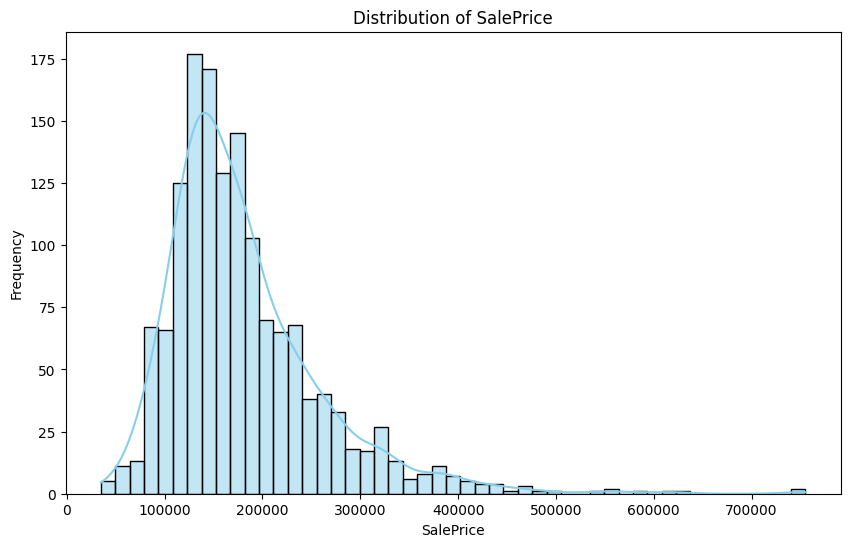

In [5]:
#Distribution of sale price
plt.figure(figsize=(10,6))
sns.histplot(train_data['SalePrice'], kde = True, color = 'skyblue') #histplot on SalePrice, with a kde and skyblue colored
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

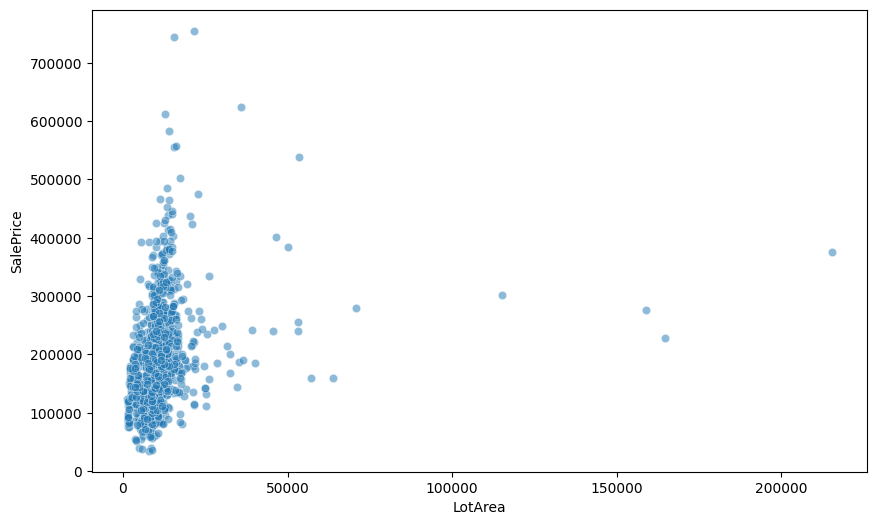

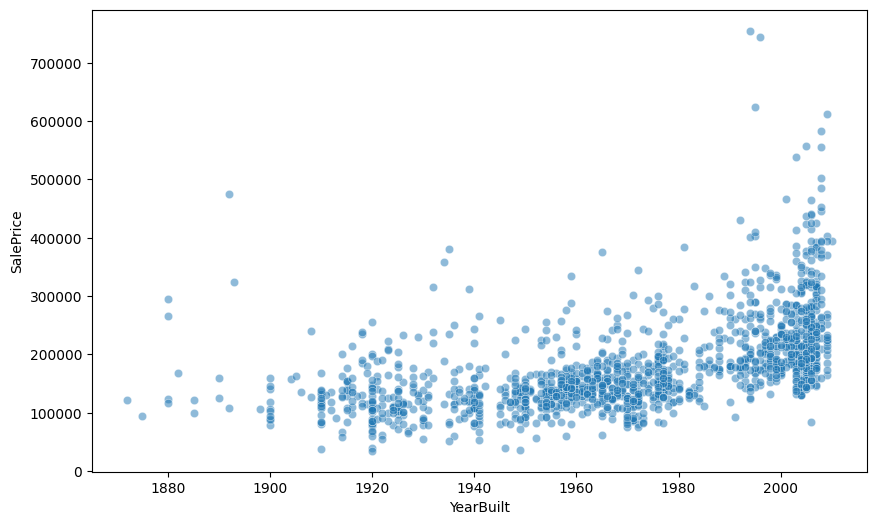

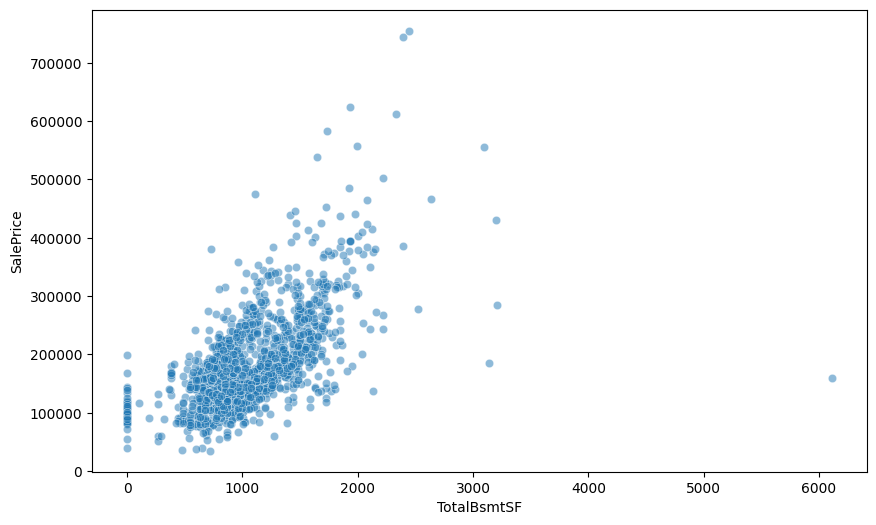

In [6]:
#checking important numerical features
num_features = ['LotArea', 'YearBuilt', 'TotalBsmtSF']

for feature in num_features:
    plt.figure(figsize = (10,6))
    sns.scatterplot(x = train_data[feature], y = train_data['SalePrice'], alpha = 0.5) #alpha on scatterplots is transparency



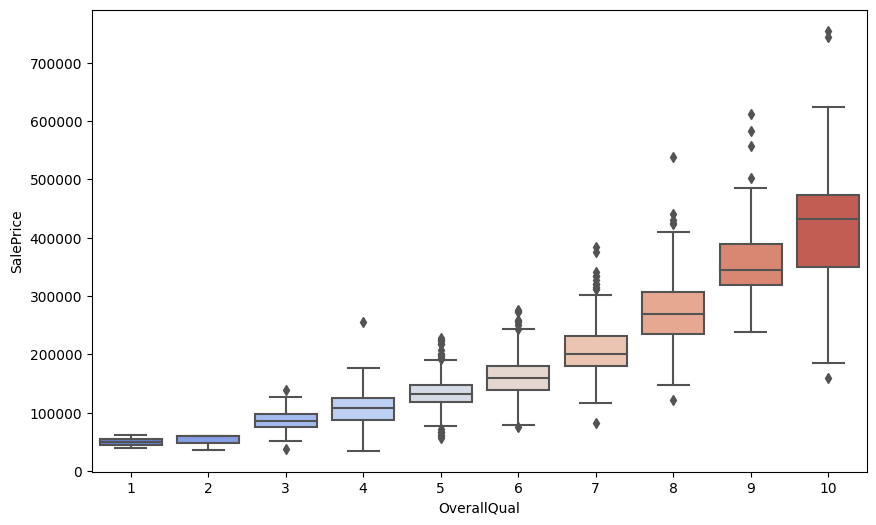

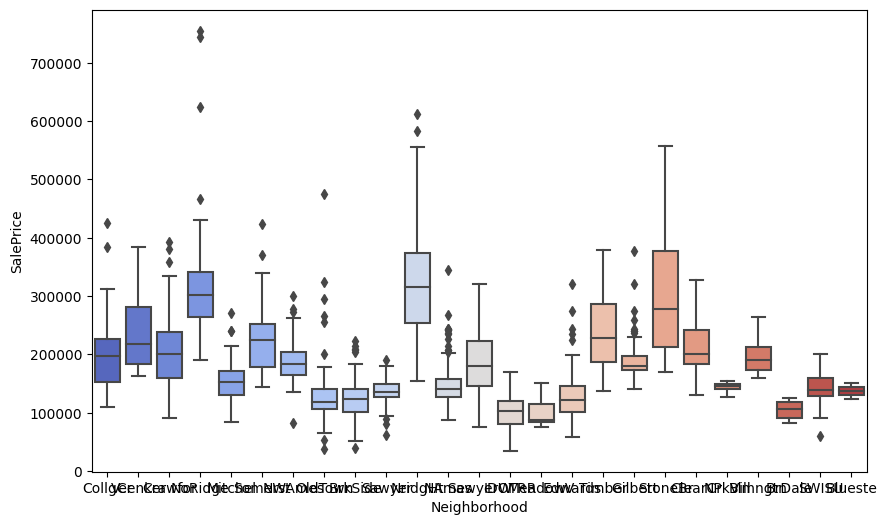

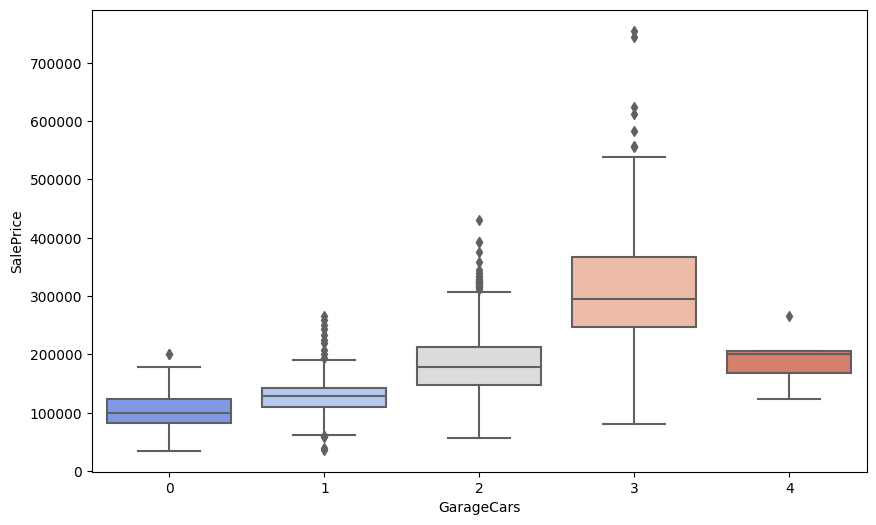

In [7]:
#important categorical features
cat_features = ['OverallQual', 'Neighborhood', 'GarageCars']

for feature in cat_features:
    plt.figure(figsize = (10,6))
    sns.boxplot(x = train_data[feature], y = train_data['SalePrice'], palette = 'coolwarm')

<Axes: >

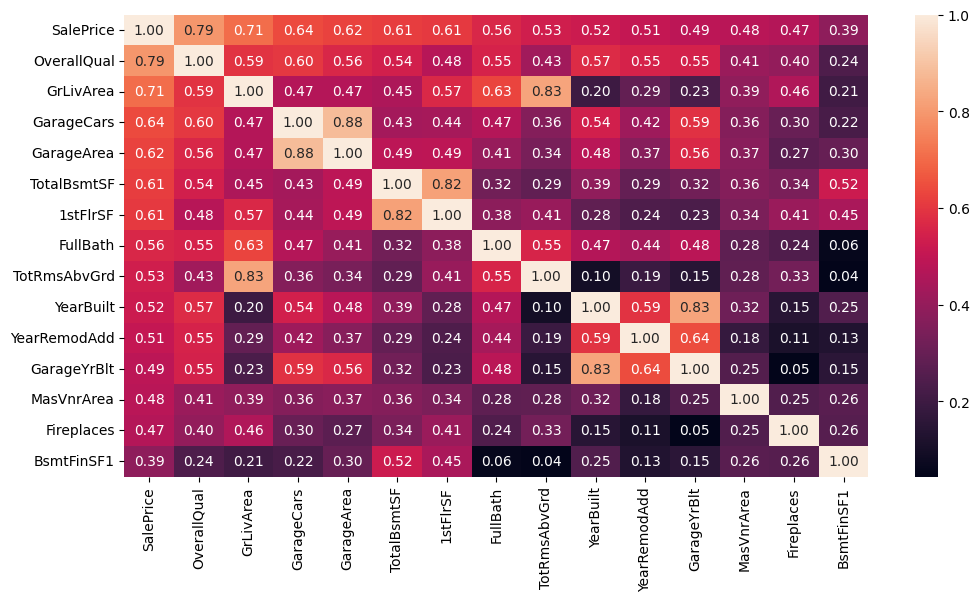

In [8]:
#heatmap for correlation analysis

#select int or float columns
numeric_features = train_data.select_dtypes(include = ['int64', 'float64']).columns

#set up correlation matrix
corr_matrix = train_data[numeric_features].corr()

#find 15 most correlated vals w SalePrice
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending = False).head(15).index

#plot
plt.figure(figsize = (12, 6))
sns.heatmap(train_data[top_corr_features].corr(), annot = True, fmt='.2f') 

In [9]:
#conclusion:  using all num features up to YearRemodAdd(0.51 corr score)
final_numerical_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

y = train_data['SalePrice']
train_id = train_data['Id']
test_id = test_data['Id']

#preprocessing function
def preprocess(df):
    df = df.copy()
    for col in df.select_dtypes(include = 'object'): #for column in non-numerical columns
        df[col] = df[col].fillna('None') #fill nulls with 'None'
        df[col] = LabelEncoder().fit_transform(df[col]) #use label encoder to numericalify values
    for col in df.select_dtypes(include = ['int64', 'float64']): #for columns in numerical columns
        df[col] = df[col].fillna(df[col].median()) #fill nulls with median
    return df

x = preprocess(train_data[final_numerical_features])

x_test = preprocess(test_data[final_numerical_features])

model = lgb.LGBMRegressor(n_estimators = 1000, learning_rate = 0.01, random_state = 42)
model.fit(x, y)
preds = model.predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 10
[LightGBM] [Info] Start training from score 180921.195890


In [10]:
output = pd.DataFrame({
    'Id' : test_id,
    'SalePrice' : preds
})
output.to_csv('submission.csv', index = False)